In [88]:
with open('inputs/day21.txt', 'r') as input:
    codes = [x.strip() for x in input.readlines()]

[('A', '2'), ('2', '0'), ('0', '8'), ('8', 'A')]

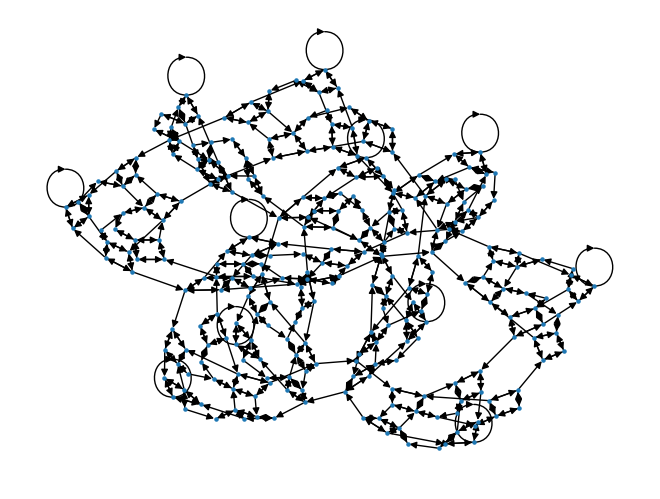

In [89]:
from functools import cache
import networkx as nx
import numpy as np

numeric_keypad = np.array([
    ['7', '8', '9'],
    ['4', '5', '6'],
    ['1', '2', '3'],
    [None, '0', 'A'],
])
directional_keypad = np.array([
    [None, '^', 'A'],
    ['<', 'v', '>']
])
numbers = ['A'] + list(str(x) for x in range(10))
directions = ['^', '>', 'v', '<', 'A']

graph = nx.DiGraph()

def get_offset(direction):
    match direction:
        case '^': return np.array([-1, 0])
        case '>': return np.array([0, 1])
        case 'v': return np.array([1, 0])
        case '<': return np.array([0, -1])

def in_numeric_keypad(i, j):
    return 0 <= i < len(numeric_keypad) and 0 <= j < len(numeric_keypad[0]) and (i, j) != (3, 0)

def in_directional_keypad(i, j):
    return 0 <= i < len(directional_keypad) and 0 <= j < len(directional_keypad[0]) and (i, j) != (0, 0)

@cache
def propagate(state, action):
    # state = (robot1pos, robot2pos, numerickeypados)
    if len(state) == 1:
        # only dealing with numeric keypad
        if action == 'A':
            return state, state[0]
        pos = np.where(numeric_keypad == state[0])
        i, j = pos[0][0], pos[1][0]
        di, dj = get_offset(action)
        if not in_numeric_keypad(i + di, j + dj):
            return None
        new_val = numeric_keypad[i + di, j + dj][0]
        return tuple(new_val, ), None
    if action == 'A':
        res = propagate(state[1:], state[0])
        if res is None:
            return None
        sub_state, output = res
        return (state[0], ) + sub_state, output
    pos = np.where(directional_keypad == state[0])
    i, j = pos[0][0], pos[1][0]
    di, dj = get_offset(action)
    if not in_directional_keypad(i + di, j + dj):
        return None
    new_val = directional_keypad[i + di, j + dj][0]
    return (new_val, ) + state[1:], None

graph = nx.DiGraph()
for a in directions:
    for d1 in directions:
        for d2 in directions:
            for n1 in numbers:
                res = propagate((d1, d2, n1), a)
                if res is not None:
                    neighbour = res[0]
                    graph.add_edge((d1, d2, n1), neighbour, action=a)

pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=5)

In [90]:
initial_state = ('A', 'A', 'A')

def truncate_path(path):
    new_path = []
    for p in path:
        new_path.append(p)
        if p[-1] == path[-1][-1]: break
    return new_path

def get_actions(path):
    actions = []
    for p1, p2 in zip(path, path[1:]):
        actions.append(graph.get_edge_data(p1, p2)['action'])
    return actions

def shortest_sequence(code):
    output = ''
    state = initial_state
    for target in code:
        path = nx.shortest_path(graph, state, ('A', 'A', target))
        actions = get_actions(path)
        output += ''.join(actions)
        output += 'A'
        state = path[-1]
    return output

sum(int(code[:-1]) * len(shortest_sequence(code)) for code in codes)

155252